# Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.ensemble import AdaBoostClassifier
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score

In [2]:
site_dic = {}
with open('site_dic.pkl', 'rb') as f:
    site_dic = pickle.load(f)

id2site = {v: k for (k, v) in site_dic.items()}
id2site[0] = 'no-site'

In [3]:
len(id2site)

48372

In [4]:
df = pd.read_csv('train_sessions.csv',index_col="session_id")
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64(9), 

# Feature Engineering

In [6]:
sites = ['site%s' % i for i in range(1, 11)]

# extracting time features from the time1 column
df['time1'] = pd.to_datetime(df['time1'])
df['hour1'] = df['time1'].dt.hour
df['day1'] = df['time1'].dt.day
df['month1'] = df['time1'].dt.month
df['day_of_week1'] = df['time1'].dt.day_of_week
# creating a time interval feature for every 20 minutes
df['time_interval'] = (df['time1']
             .apply(lambda x: pd.to_datetime(x).hour * 100 + pd.to_datetime(x).minute // 20 * 20))
df.sort_values(by='time1', inplace=True)

In [7]:
sites_list = df[sites].fillna(0).astype(str).apply(lambda row: ' '.join(row), axis=1).to_list()
sites_list

['56 55.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0',
 '56 55.0 56.0 55.0 0.0 0.0 0.0 0.0 0.0 0.0',
 '946 946.0 951.0 946.0 946.0 945.0 948.0 784.0 949.0 946.0',
 '945 948.0 949.0 948.0 945.0 946.0 947.0 945.0 946.0 946.0',
 '947 950.0 948.0 947.0 950.0 952.0 946.0 951.0 946.0 947.0',
 '952 947.0 953.0 946.0 947.0 946.0 953.0 955.0 946.0 947.0',
 '953 947.0 946.0 953.0 955.0 947.0 953.0 946.0 953.0 1033.0',
 '946 947.0 954.0 953.0 946.0 954.0 946.0 956.0 957.0 956.0',
 '946 956.0 946.0 946.0 955.0 954.0 946.0 946.0 946.0 948.0',
 '948 946.0 948.0 784.0 49.0 53.0 812.0 982.0 52.0 52.0',
 '52 52.0 52.0 747.0 747.0 747.0 23.0 747.0 568.0 23.0',
 '513 1116.0 747.0 23.0 747.0 747.0 29.0 49.0 52.0 21.0',
 '4222 3358.0 4222.0 3356.0 4222.0 3870.0 21.0 3870.0 3358.0 21.0',
 '38667 181.0 23.0 181.0 38667.0 23.0 182.0 181.0 38667.0 55.0',
 '56 55.0 679.0 676.0 814.0 22.0 39.0 815.0 752.0 50.0',
 '570 23.0 21.0 3356.0 48.0 222.0 570.0 513.0 1379.0 21.0',
 '820 820.0 980.0 49.0 56.0 55.0 49.0 784.0 222.0 50

In [8]:
# number of nulls for each row
df[df['target'] == 1][sites].isnull().sum(axis=1).value_counts(normalize=True)

0    0.983021
8    0.003047
5    0.003047
3    0.002612
6    0.002612
1    0.001741
4    0.001741
9    0.001306
2    0.000435
7    0.000435
Name: proportion, dtype: float64

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
features = 30000
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=features, tokenizer=lambda s: s.split())
X_tfidf = vectorizer.fit_transform(sites_list)

c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
vectorizer.get_feature_names_out()

array(['0.0', '0.0 0.0', '0.0 0.0 0.0', ..., '9980.0', '9997.0', '9999.0'],
      shape=(30000,), dtype=object)

In [11]:
X_tfidf.shape

(253561, 30000)

# Dataset Exploration

In [12]:
df["target"].value_counts(normalize=True)

target
0    0.990941
1    0.009059
Name: proportion, dtype: float64

### Hour Exploretion

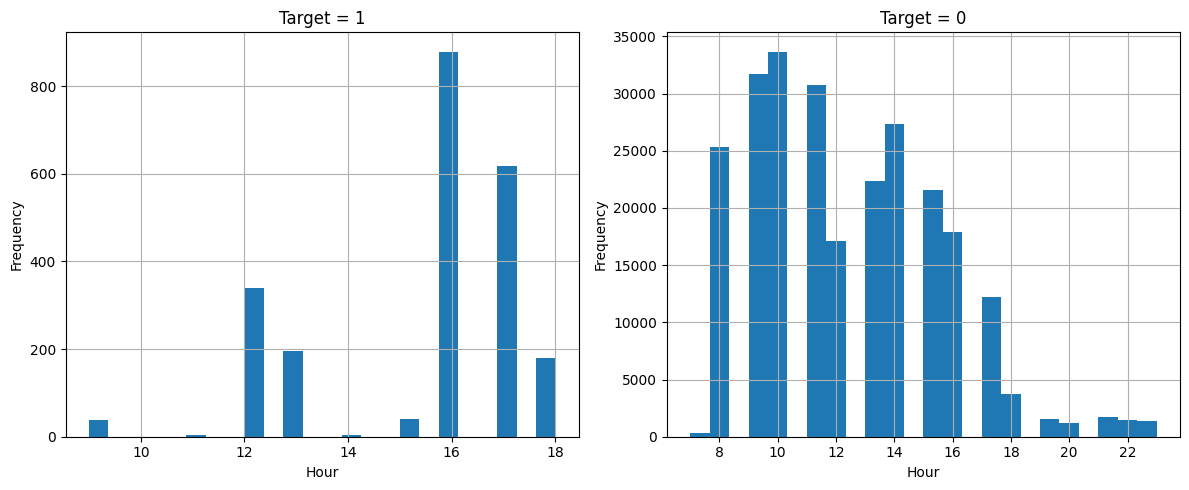

In [13]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
df[df["target"] == 1]['hour1'].hist(bins=24)
plt.title("Target = 1")
plt.xlabel("Hour")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
df[df["target"] == 0]['hour1'].hist(bins=24)
plt.title("Target = 0")
plt.xlabel("Hour")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
df[df["target"]==1]['hour1'].value_counts(normalize=True) * 100

hour1
16    38.267305
17    26.904658
12    14.801916
13     8.532869
18     7.792773
15     1.741402
9      1.654332
14     0.174140
11     0.130605
Name: proportion, dtype: float64

In [15]:
df[df["target"]==0]['hour1'].value_counts(normalize=True) * 100

hour1
10    13.402636
9     12.617406
11    12.256033
14    10.865862
8     10.096552
13     8.897415
15     8.596536
16     7.108062
12     6.797631
17     4.860227
18     1.480117
21     0.678569
19     0.612901
22     0.583848
23     0.532906
20     0.477585
7      0.135714
Name: proportion, dtype: float64

### Time Interval Exploration

In [16]:
df['time_interval']

session_id
21669      800
54843      820
77292      840
114021     840
146670     840
          ... 
12224     2320
164438    2320
12221     2320
156968    2320
204762    2320
Name: time_interval, Length: 253561, dtype: int64

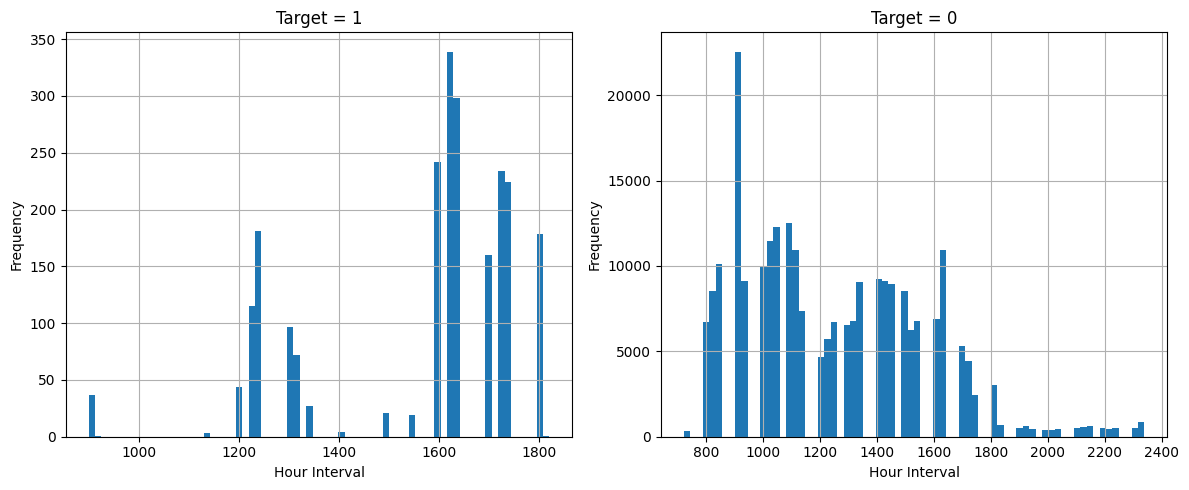

In [17]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
df[df["target"] == 1]['time_interval'].hist(bins=72)
plt.title("Target = 1")
plt.xlabel("Hour Interval")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
df[df["target"] == 0]['time_interval'].hist(bins=72)
plt.title("Target = 0")
plt.xlabel("Hour Interval")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [18]:
df[df["target"]==1]['time_interval'].value_counts(normalize=True) * 100

time_interval
1620    14.758380
1640    12.973444
1600    10.535481
1720    10.187201
1740     9.751850
1240     7.879843
1800     7.749238
1700     6.965607
1220     5.006530
1300     4.222899
1320     3.134523
1200     1.915542
900      1.610797
1340     1.175446
1500     0.914236
1540     0.827166
1400     0.174140
1140     0.130605
1820     0.043535
920      0.043535
Name: proportion, dtype: float64

In [19]:
df[df["target"]==0]['time_interval'].value_counts(normalize=True) * 100

time_interval
1100    4.986787
1040    4.894454
920     4.614668
1020    4.551388
900     4.361946
1120    4.344833
840     4.026442
1000    3.956794
1400    3.668253
940     3.640792
1420    3.628853
1340    3.594626
1440    3.568756
1500    3.399612
820     3.390458
1140    2.924414
1600    2.748106
1540    2.706715
1320    2.693183
800     2.679652
1240    2.675672
1300    2.609606
1520    2.490210
1220    2.274500
1620    2.196495
1640    2.163462
1700    2.115305
1200    1.847459
1720    1.765872
1740    0.979050
1800    0.734287
1820    0.474003
1840    0.271826
2140    0.259886
1920    0.240385
2120    0.217699
2200    0.208148
1900    0.202178
2240    0.200984
2100    0.200984
2300    0.199392
2040    0.186258
2320    0.176707
2220    0.174717
1940    0.170339
2340    0.156807
2000    0.146062
2020    0.145266
740     0.132928
720     0.002786
Name: proportion, dtype: float64

### Day Exploration

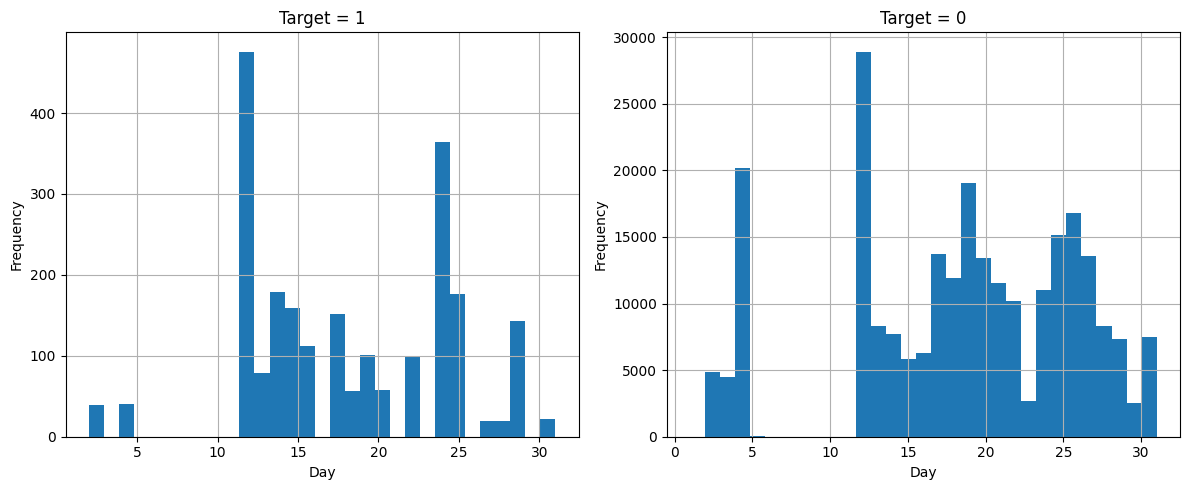

In [20]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
df[df["target"] == 1]['day1'].hist(bins=31)
plt.title("Target = 1")
plt.xlabel("Day")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
df[df["target"] == 0]['day1'].hist(bins=31)
plt.title("Target = 0")
plt.xlabel("Day")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [21]:
df[df["target"]==1]['day1'].value_counts(normalize=True) * 100

day1
12    20.722682
24    15.846757
14     7.792773
25     7.662168
15     6.922072
17     6.617327
29     6.225512
16     4.875925
19     4.397040
22     4.353505
13     3.439269
20     2.525033
18     2.437963
4      1.784937
2      1.697867
31     0.957771
28     0.870701
27     0.870701
Name: proportion, dtype: float64

In [22]:
df[df["target"]==0]['day1'].value_counts(normalize=True) * 100

day1
12    11.509806
4      8.025025
19     7.593209
26     6.680623
25     6.037873
17     5.452035
27     5.388356
20     5.350548
18     4.744412
21     4.579247
24     4.371896
22     4.064649
28     3.317228
13     3.296135
14     3.064904
31     2.977347
29     2.914066
16     2.498567
15     2.332208
2      1.934221
3      1.774229
23     1.055066
30     1.002929
5      0.034625
1      0.000796
Name: proportion, dtype: float64

### Weekday Exploration

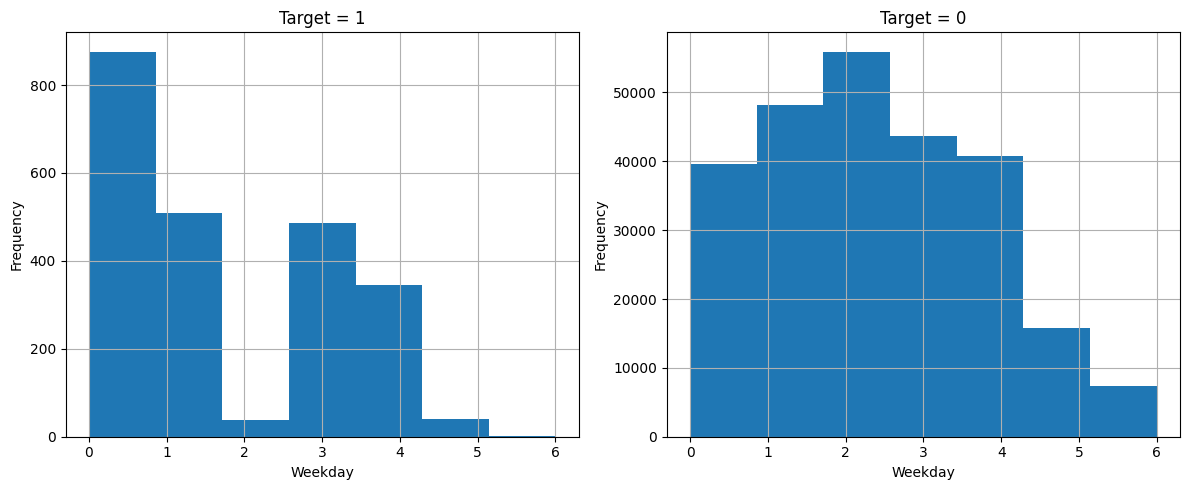

In [23]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
df[df["target"] == 1]['day_of_week1'].hist(bins=7)
plt.title("Target = 1")
plt.xlabel("Weekday")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
df[df["target"] == 0]['day_of_week1'].hist(bins=7)
plt.title("Target = 0")
plt.xlabel("Weekday")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [24]:
df[df["target"]==1]['day_of_week1'].value_counts(normalize=True) * 100

day_of_week1
0    38.136700
1    22.115803
3    21.201567
4    15.063126
5     1.784937
2     1.654332
6     0.043535
Name: proportion, dtype: float64

In [25]:
df[df["target"]==0]['day_of_week1'].value_counts(normalize=True) * 100

day_of_week1
2    22.260650
1    19.163509
3    17.376146
4    16.235513
0    15.775041
5     6.271491
6     2.917648
Name: proportion, dtype: float64

### Month Exploration

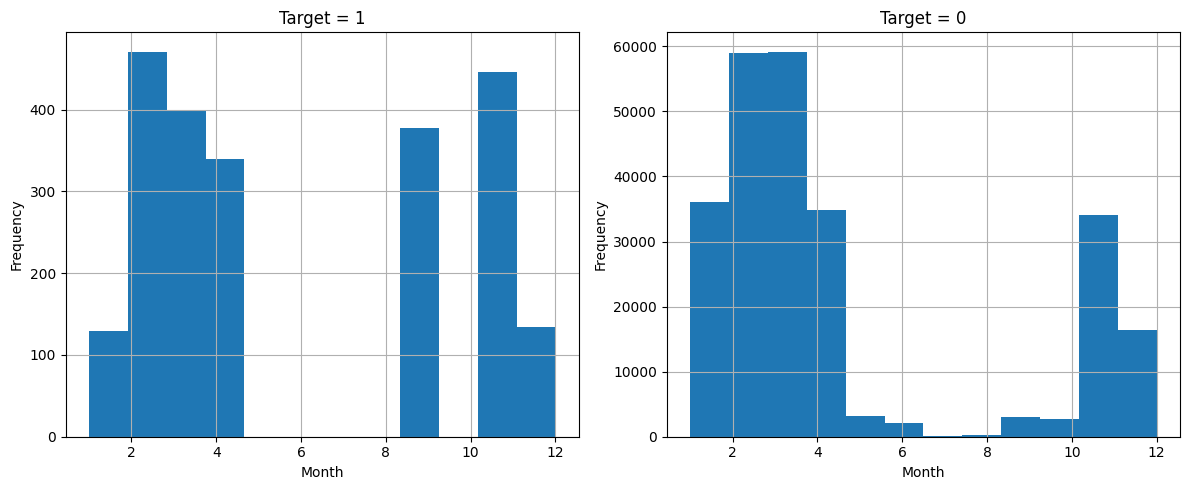

In [26]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
df[df["target"] == 1]['month1'].hist(bins=12)
plt.title("Target = 1")
plt.xlabel("Month")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
df[df["target"] == 0]['month1'].hist(bins=12)
plt.title("Target = 0")
plt.xlabel("Month")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [27]:
df[df["target"]==1]['month1'].value_counts(normalize=True) * 100

month1
2     20.505007
11    19.416630
3     17.414018
9     16.412712
4     14.801916
12     5.833696
1      5.616021
Name: proportion, dtype: float64

In [28]:
df[df["target"]==0]['month1'].value_counts(normalize=True) * 100

month1
3     23.555702
2     23.489636
1     14.368553
4     13.874252
11    13.550290
12     6.534163
5      1.285103
9      1.228588
10     1.109590
6      0.833386
8      0.115416
7      0.055320
Name: proportion, dtype: float64

Text(0, 0.5, 'Frequency')

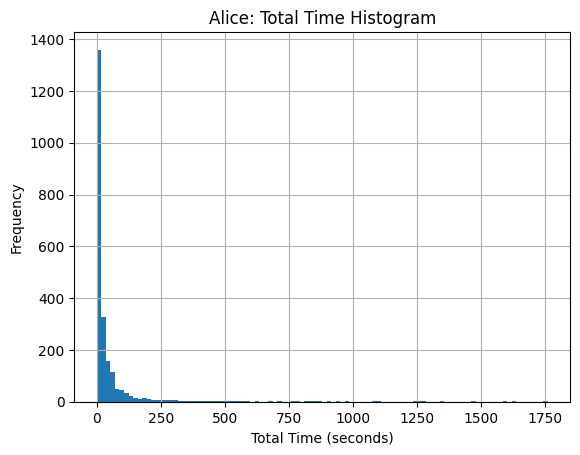

In [29]:
df["total_time"] = pd.to_datetime(df["time10"]) - pd.to_datetime(df["time1"])
df["total_time"] = df["total_time"].dt.total_seconds() # Convert to minutes
df[df['target'] == 1]["total_time"].hist(bins=100)
plt.title("Alice: Total Time Histogram")
plt.xlabel("Total Time (seconds)")
plt.ylabel("Frequency")

- We found that the time difference between the first and last site is small most of the time. and won't differentiate alice from the other users.

# Model Selection & Training

In [30]:
def feature_extract(df):
  df['time1'] = pd.to_datetime(df['time1'])
  df['hour1'] = df['time1'].dt.hour
  df['day1'] = df['time1'].dt.day
  df['month1'] = df['time1'].dt.month
  df['day_of_week1'] = df['time1'].dt.day_of_week
  df['time_interval'] = (df['time1']
             .apply(lambda x: pd.to_datetime(x).hour * 100 + pd.to_datetime(x).minute // 20 * 20))
  
  df['alice_opening_hours_interval'] = df['time_interval'].apply(lambda x: 1 if 1620 <= x <= 1740 else 0)
  df['alice_opening_hours_interval_2'] = df['time_interval'].apply(lambda x: 1 if 1200 <= x <= 1320 else 0)
  df['alice_opening_hours_interval_3'] = df['time_interval'].apply(lambda x: 1 if x in [1700, 1800] else 0)
  df['alice_opening_hours_interval_4'] = df['time_interval'].apply(lambda x: 1 if 900 <= x <= 1120 else 0)
  
  df['alice_opening_hours'] = df['hour1'].apply(lambda x: 1 if x in [16, 17] else 0)
  df['alice_opening_hours_2'] = df['hour1'].apply(lambda x: 1 if x in [12, 18] else 0)
  df['alice_off_hours'] = df['hour1'].apply(lambda x: 1 if x in [9, 10, 11, 8] else 0)
  df['alice_off_hours_2'] = df['hour1'].apply(lambda x: 1 if x in [14, 15] else 0)
  
  df['alice_opening_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [0] else 0)
  df['alice_off_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [2, 5, 6] else 0)
  
  df['alice_opening_days'] = df['day1'].apply(lambda x: 1 if x in [24, 14, 15, 29] else 0)
  df['alice_off_days'] = df['day1'].apply(lambda x: 1 if x in [4, 26, 1, 3, 5, 27] else 0)
  
  df['alice_opening_months'] = df['month1'].apply(lambda x: 1 if x in [9] else 0)
  # df['alice_off_months'] = df['month1'].apply(lambda x: 1 if x in [5, 6, 7, 8, 10] else 0)
  
  return df

In [31]:
df = feature_extract(df)
df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,alice_opening_hours_interval_4,alice_opening_hours,alice_opening_hours_2,alice_off_hours,alice_off_hours_2,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,0,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,0,0,0,1,0,0,1,0,0,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,0,0,0,1,0,0,1,0,0,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,0,0,0,1,0,0,1,0,0,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,0,0,0,0,0,0,1,0,0,0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,0,0,0,0,0,0,1,0,0,0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,0,0,0,0,0,0,1,0,0,0


In [32]:
features_arr = ["alice_opening_hours", "alice_opening_hours_2", "alice_off_hours", "alice_off_hours_2", "alice_opening_days_of_week", "alice_off_days_of_week", "alice_opening_days", "alice_off_days", "alice_opening_months"]
X = df[features_arr]
X_combined = hstack([X.values, X_tfidf])  # Combine the original features with TF-IDF features
y = df['target']

In [33]:
X

,alice_opening_hours,alice_opening_hours_2,alice_off_hours,alice_off_hours_2,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months
session_id,,,,,,,,,
21669,0,0,1,0,0,1,0,0,0
54843,0,0,1,0,0,1,0,0,0
77292,0,0,1,0,0,1,0,0,0
114021,0,0,1,0,0,1,0,0,0
146670,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
12224,0,0,0,0,0,1,0,0,0
164438,0,0,0,0,0,1,0,0,0
12221,0,0,0,0,0,1,0,0,0


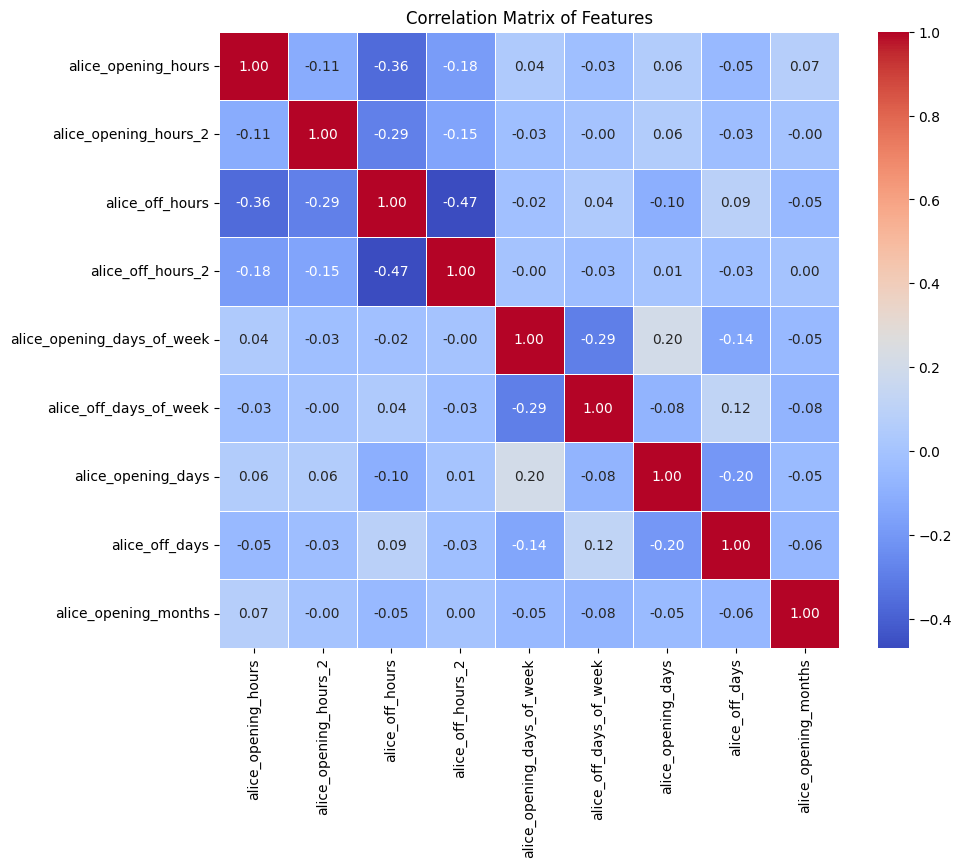

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = X.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X_combined, y,test_size=0.2,random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((202848, 30009), (202848,), (50713, 30009), (50713,))

In [37]:
reg = LogisticRegression(random_state=42, penalty='l2', solver='liblinear',C=5)
reg.fit(x_train,y_train)

LogisticRegression(C=5, random_state=42, solver='liblinear')

In [38]:
y_pred = reg.predict(x_test)

In [39]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99446


### Under Sampler

In [40]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(x_train,y_train)

### SVM Classification Model

In [41]:
pca = PCA(n_components=X.shape[1])
model = make_pipeline(pca, SVR(C=1.0, epsilon=0.2))
model.fit(X_train_under, y_train_under)

Pipeline(steps=[('pca', PCA(n_components=9)), ('svr', SVR(epsilon=0.2))])

In [42]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred > 0.5)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

Accuracy: 83.718%


In [43]:
auc = roc_auc_score(y_test, y_pred > 0.5)
print(f"AUC: {round(auc * 100, 3)}%")

AUC: 89.09%


### Adaboost Classification Model

In [44]:
pca = PCA(n_components=X.shape[1])
model = make_pipeline(pca, AdaBoostClassifier(n_estimators=1500, random_state=42))
model.fit(X_train_under, y_train_under)

Pipeline(steps=[('pca', PCA(n_components=9)),
                ('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=1500, random_state=42))])

In [45]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

Accuracy: 90.056%


In [46]:
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {round(auc * 100, 3)}%")

AUC: 91.163%


### Logistic Regression

In [54]:
#model = LogisticRegression(random_state=42, penalty='l1', solver='saga', C=4,max_iter=1000) # still didnt converage
model = LogisticRegression(random_state=42, penalty='l2', solver='saga', C=5)
model.fit(X_train_under, y_train_under)

c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=5, random_state=42, solver='saga')

In [55]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

Accuracy: 89.5%


In [56]:
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {round(auc * 100, 3)}%")

AUC: 92.344%


In [57]:
model.coef_[0][0:9]

array([ 1.4394499 ,  1.07174168, -2.7285137 , -2.1577943 ,  0.07174459,
       -2.02829553,  0.75497519, -0.7183975 ,  1.77529101])

In [58]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
time_split = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_combined, y, cv=time_split, scoring='roc_auc')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.5f}")

c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-validation scores: [0.86711156 0.90555096 0.96821911 0.97377775 0.9682796 ]
Mean cross-validation score: 0.93659


c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Grid Search

In [59]:
params = {
    'C': [ 0.1, 0.5, 1, 5, 10,15,20,25, 50, 100], # l2 saga 5.0
    #'C':np.arange(4,7,step=0.1),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'fit_intercept': [True, False]   
}
params

{'C': [0.1, 0.5, 1, 5, 10, 15, 20, 25, 50, 100],
 'penalty': ['l1', 'l2'],
 'solver': ['liblinear', 'saga'],
 'fit_intercept': [True, False]}

In [60]:
from sklearn.model_selection import GridSearchCV

model_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="roc_auc"
)

In [136]:
model_grid.fit(X_combined, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [ ]:
df_grid = pd.DataFrame(model_grid.cv_results_)
df_grid.set_index("rank_test_score",inplace=True)
df_grid.sort_index()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,207.125737,5.891774,0.029553,0.010735,4.0,True,l1,saga,"{'C': 4.0, 'fit_intercept': True, 'penalty': '...",0.945009,0.929107,0.943853,0.977956,0.965080,0.952201,0.017227
2,180.201214,5.598095,0.021630,0.002310,4.1,True,l1,saga,"{'C': 4.1, 'fit_intercept': True, 'penalty': '...",0.944952,0.928987,0.943690,0.977958,0.965130,0.952143,0.017288
3,189.349720,14.206076,0.023203,0.006176,4.2,True,l1,saga,"{'C': 4.199999999999999, 'fit_intercept': True...",0.944922,0.928870,0.943498,0.977951,0.965164,0.952081,0.017344
4,23.059009,1.544337,0.018258,0.000897,5.2,True,l2,saga,"{'C': 5.199999999999996, 'fit_intercept': True...",0.943079,0.929700,0.942041,0.978494,0.967047,0.952072,0.017913
5,23.153850,1.428506,0.023584,0.004386,5.3,True,l2,saga,"{'C': 5.299999999999995, 'fit_intercept': True...",0.943081,0.929665,0.942052,0.978484,0.967064,0.952069,0.017920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,15.633499,0.892156,0.025299,0.004685,4.0,False,l2,saga,"{'C': 4.0, 'fit_intercept': False, 'penalty': ...",0.933993,0.930873,0.908634,0.965447,0.937761,0.935342,0.018151
237,5.426532,0.685937,0.034273,0.009070,4.0,False,l2,liblinear,"{'C': 4.0, 'fit_intercept': False, 'penalty': ...",0.933991,0.930870,0.908635,0.965446,0.937763,0.935341,0.018150
238,5.348124,1.011450,0.021686,0.001421,6.7,False,l1,liblinear,"{'C': 6.69999999999999, 'fit_intercept': False...",0.936107,0.920399,0.911345,0.967013,0.941822,0.935337,0.019208


In [138]:
print("Best parameters:", model_grid.best_params_)
print("Best ROC AUC score:", model_grid.best_score_)

Best parameters: {'C': np.float64(4.0), 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best ROC AUC score: 0.9522012276964655


# Submission

In [61]:
model.fit(X_combined, y)

c:\Users\mroan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=5, random_state=42, solver='saga')

In [62]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

# calculate perceicion and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["Not Alice", "Alice"]))


Accuracy: 99.645%
Precision: 0.94845
Recall: 0.62585
              precision    recall  f1-score   support

   Not Alice       1.00      1.00      1.00     50272
       Alice       0.95      0.63      0.75       441

    accuracy                           1.00     50713
   macro avg       0.97      0.81      0.88     50713
weighted avg       1.00      1.00      1.00     50713



In [63]:
test_df = pd.read_csv('test_sessions.csv', index_col="session_id")
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [64]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [65]:
test_df = feature_extract(test_df)
test_df_X = test_df[features_arr]

# create tf-idf
test_df_X_tfidf = vectorizer.transform(test_df[sites].fillna(0).astype(str).apply(lambda row: ' '.join(row), axis=1))
test_df_X_combined = hstack([test_df_X.values, test_df_X_tfidf])  # Combine the original features with TF-IDF features

y_pred_proba = model.predict_proba(test_df_X_combined)[:, 1]

In [66]:
write_to_submission_file(np.round(y_pred_proba, 6), 'submission.csv', target='target', index_label="session_id")